# **TYRE-DDR**: "Risk detection in tyre defects" Model

In [2]:
#mount the google drive into google colab 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print('GPU is available !!, ' + str(torch.cuda.get_device_properties(0)) if torch.cuda.is_available() else 'GPU is not available !!')

GPU is available !!, _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk

/content/drive/MyDrive/FYP_CODE1/implementation_risk


In [ ]:
!ls # check weather, I am inside the current working directory 

Tyre_risk_detect.ipynb


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone the repository 

Cloning into 'yolov5'...
remote: Enumerating objects: 15393, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 15393 (delta 9), reused 17 (delta 6), pack-reused 15369
Receiving objects: 100% (15393/15393), 14.31 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (10523/10523), done.
Updating files: 100% (141/141), done.


### Install the requirements for YOLOv5 

In [3]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5

/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00


### Split the dataset into train and validation

In [ ]:
import os
from random import choice 
import shutil # to copy and removal of files and directory 

In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk
# go back from the yolov5 folder to current working derectory 

/content/drive/MyDrive/FYP_CODE1/implementation_risk


Unzip the dataset

In [ ]:
!unzip realdataset_risks.zip

Archive:  realdataset_risks.zip
  inflating: realdataset_risks/0000.jpg  
  inflating: realdataset_risks/0000.txt  
  inflating: realdataset_risks/0001.jpg  
  inflating: realdataset_risks/0001.txt  
  inflating: realdataset_risks/0002.jpg  
  inflating: realdataset_risks/0002.txt  
  inflating: realdataset_risks/0003.jpg  
  inflating: realdataset_risks/0003.txt  
  inflating: realdataset_risks/0004.jpg  
  inflating: realdataset_risks/0004.txt  
  inflating: realdataset_risks/0005.jpg  
  inflating: realdataset_risks/0005.txt  
  inflating: realdataset_risks/0006.jpg  
  inflating: realdataset_risks/0006.txt  
  inflating: realdataset_risks/0007.jpg  
  inflating: realdataset_risks/0007.txt  
  inflating: realdataset_risks/0008.jpg  
  inflating: realdataset_risks/0008.txt  
  inflating: realdataset_risks/0009.jpg  
  inflating: realdataset_risks/0009.txt  
  inflating: realdataset_risks/0010.jpg  
  inflating: realdataset_risks/0010.txt  
  inflating: realdataset_risks/0011.jpg  
  

### Dataset Preprocessing

In [ ]:
#arrays to store file names 
imgs=[]
txts=[]

In [ ]:
#specify the path
train_path="/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/train" # train images path (newly created folder to store images for train set)
val_path="/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/validation" # validation images path  (newly created folder to store images for train set)
crs_path="/content/drive/MyDrive/FYP_CODE1/implementation_risk/realdataset_risks" #source path

In [ ]:
#set up the ratio 
train_ratio=0.7
val_ratio=0.3
# storing files names to specific array 

#dirname - root director name (./realdataset_defects1)
#dirs - subdirectories of the root directory 
#files - files of root and directories 
for(dirname,dirs,files) in os.walk(crs_path): # os.walk() will give the file names or folder names in a directory tree by walking the tree
  for filenames in files:
    if filenames.endswith('.txt'):
      txts.append(filenames) # if file names are end with .txt it will appent to txts array 
    else :
      imgs.append(filenames) # if file names are end with .jpg or other format it will append to imgs array 
    
#count for train 
countfortrain= int(len(imgs)*train_ratio)
#count for validation
countforval= int(len(imgs)*val_ratio)

print("count for train : ", int(len(imgs)*train_ratio))
print("count for val : ", int(len(imgs)*val_ratio))

count for train :  217
count for val :  93


* **trainLabelPath**=  labels of train set need to store in this path 
* **trainImagesPath**= images of train set need to store in this path 
* **validationImagesPath**= images of validation set need to store in this path
* **validationLabelPath**= labels of validation set need to store in this path

In [ ]:
trainLabelPath= "/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/labels/train" # labels of train set need to store in this path
trainImagesPath="/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/train" # images of train set need to store in this path
validationImagesPath="/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/validation" # images of validation set need to store in this path
validationLabelPath="/content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/labels/validation" #labels of validation set need to store in this path


In [ ]:
#import copy 
# imgs2=copy.deepcopy(imgs)
for x in range(countfortrain):
  filejpg=choice(imgs) # choice will choose the random elements(images file names from imgs array)
  filetxt=filejpg[:-4]+".txt" # to remove the .jpg extention from image file name and add the .txt to end of the file name

  # use shutil.copy() to copy files from crs_path directory to train folders
  # in here we will use os.path.join to join the directory path with the file name 
  # ex: 1 image - os.path.join(crs_path,filejpg) = /content/drive/MyDrive/FYP/Implementation/realdataset_defects/0000.jpg
  
  if filejpg in imgs: 
    shutil.copy(os.path.join(crs_path,filejpg),os.path.join(trainImagesPath,filejpg))
    shutil.copy(os.path.join(crs_path,filetxt),os.path.join(trainLabelPath,filetxt))

    imgs.remove(filejpg)
    txts.remove(filetxt)
for y in range(countforval):
  filejpg=choice(imgs) # choice will choose the random elements(images)
  filetxt=filejpg[:-4]+".txt" # to remove the .jpg extention from image file name and add the .txt to end of the file name 
  if filejpg in imgs:
    # use shutil.copy() to copy files from crs_path directory to validation folders 
    shutil.copy(os.path.join(crs_path,filejpg),os.path.join(validationImagesPath,filejpg))
    shutil.copy(os.path.join(crs_path,filetxt),os.path.join(validationLabelPath,filetxt))

    imgs.remove(filejpg)
    txts.remove(filetxt)


### Create the custom dataset config file for detect tyre defects

In Yolov5, the details of the dataset should describe in the "dataset config yaml file". That file should have the train path and the validation path of the dataset, number of classes of the dataset and the names of the classes we are going to detect. 

In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5

/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5


In [ ]:
f = open("risks_dataset.yaml", "x") # create the new yaml file inside the Yolov5 directory. 

In [ ]:
data='''train: /content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/train
val: /content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/validation
test: /content/drive/MyDrive/FYP_CODE1/implementation_risk/test
nc: 3
names: ['low_risk','high_risk','medium_risk']
'''

In [ ]:
with open('/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/risks_dataset.yaml', 'w') as writeToFile:
    writeToFile.write(data)

In [ ]:
!cat risks_dataset.yaml #  show the content of the dataset configuration file 

train: /content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/train
val: /content/drive/MyDrive/FYP_CODE1/implementation_risk/risks_dataset/images/validation
test: /content/drive/MyDrive/FYP_CODE1/implementation_risk/test
nc: 3
names: ['low_risk','high_risk','medium_risk']


### install albumentations package to add the additional augmentations to the dataset

In [ ]:
!pip install -U albumentations 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


###  display the predifined yolov5m model architecture 

In [ ]:
%cat /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

### change the predefined yolov5m model architecture file (yolov5m.yaml) according to my custom created Dataset and save as new model configuration file with it. 

In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models

/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models


In [ ]:
f = open("yolov5m_custom.yaml", "x") # create the new yaml file inside the Yolov5 directory. 

In [ ]:
data1 = '''
# Parameters
nc: 3  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
'''


In [ ]:
with open('/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models/yolov5m_custom.yaml', 'w') as writeToFile:
    writeToFile.write(data1)

In [ ]:
%cat /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models/yolov5m_custom.yaml


# Parameters
nc: 3  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

### Train the model for "tyre defects detection" with customized yolov5m model architecture 

In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5

/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5


In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

**Understanding the Parameters which I have used in below code**


In [ ]:
!python train.py --data /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/risks_dataset.yaml --img 640 --cfg /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/models/yolov5m_custom.yaml  --weights '' --epochs 1000 --batch 16 --cache --patience 0 

Streaming output truncated to the last 5000 lines.
                   all         93        205   2.39e-05     0.0163   1.29e-05   1.91e-06

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      3/999      7.96G     0.1087    0.03372    0.03762         30        640: 100% 14/14 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:02<00:00,  1.05it/s]
                   all         93        205   2.39e-05     0.0163   1.29e-05   2.52e-06

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      4/999      7.96G     0.1076    0.03396     0.0375         38        640: 100% 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:02<00:00,  1.47it/s]
                   all         93        205   2.39e-05     0.0163   1.27e-05    2.5e-06

      Epoch    GPU_mem   box_loss   obj_loss 

In [5]:
import matplotlib.pyplot as plt

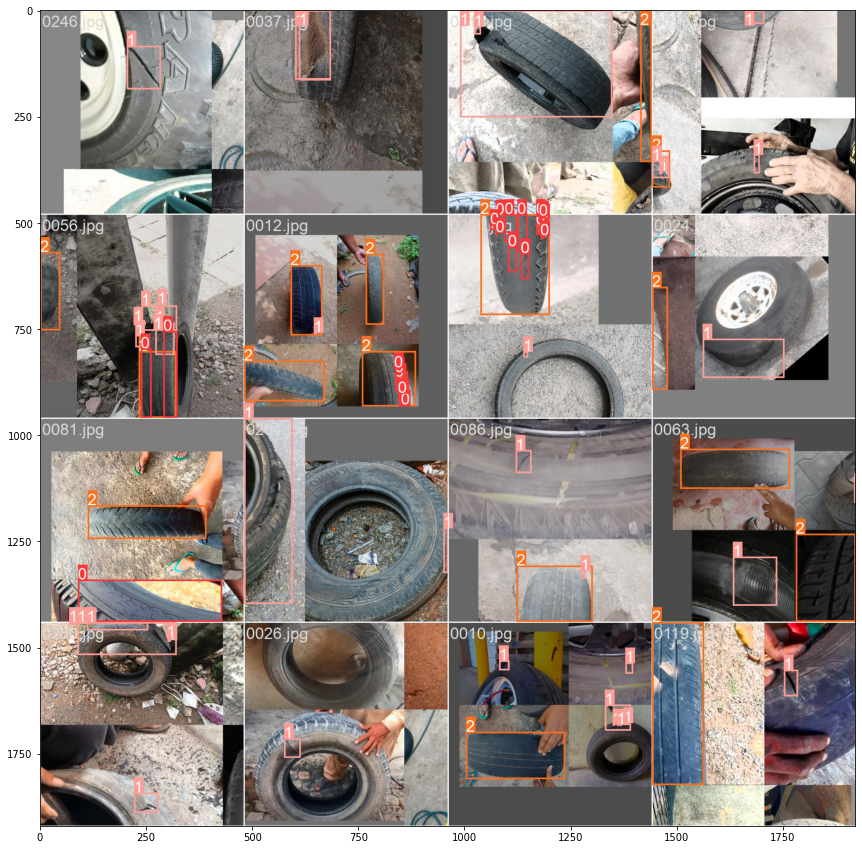

In [ ]:
# One mosaic batch of train images  
plt.figure(figsize=(15,15))
plt.imshow(plt.imread(f'/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/train_batch0.jpg'))

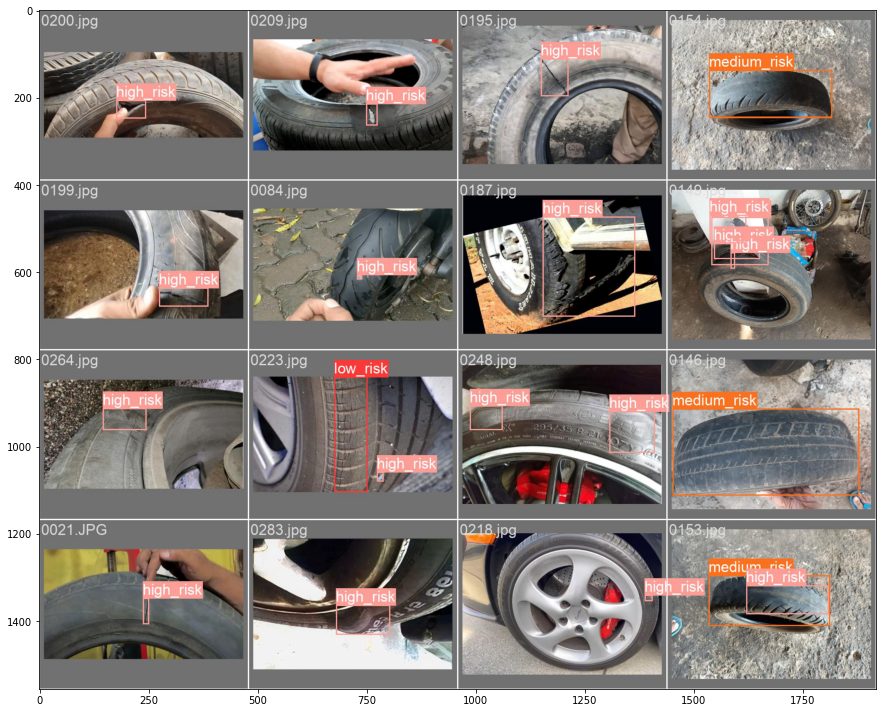

In [ ]:
#one batch with validation image with true labels 
plt.figure(figsize=(15,15))
plt.imshow(plt.imread(f'/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/val_batch0_labels.jpg'))

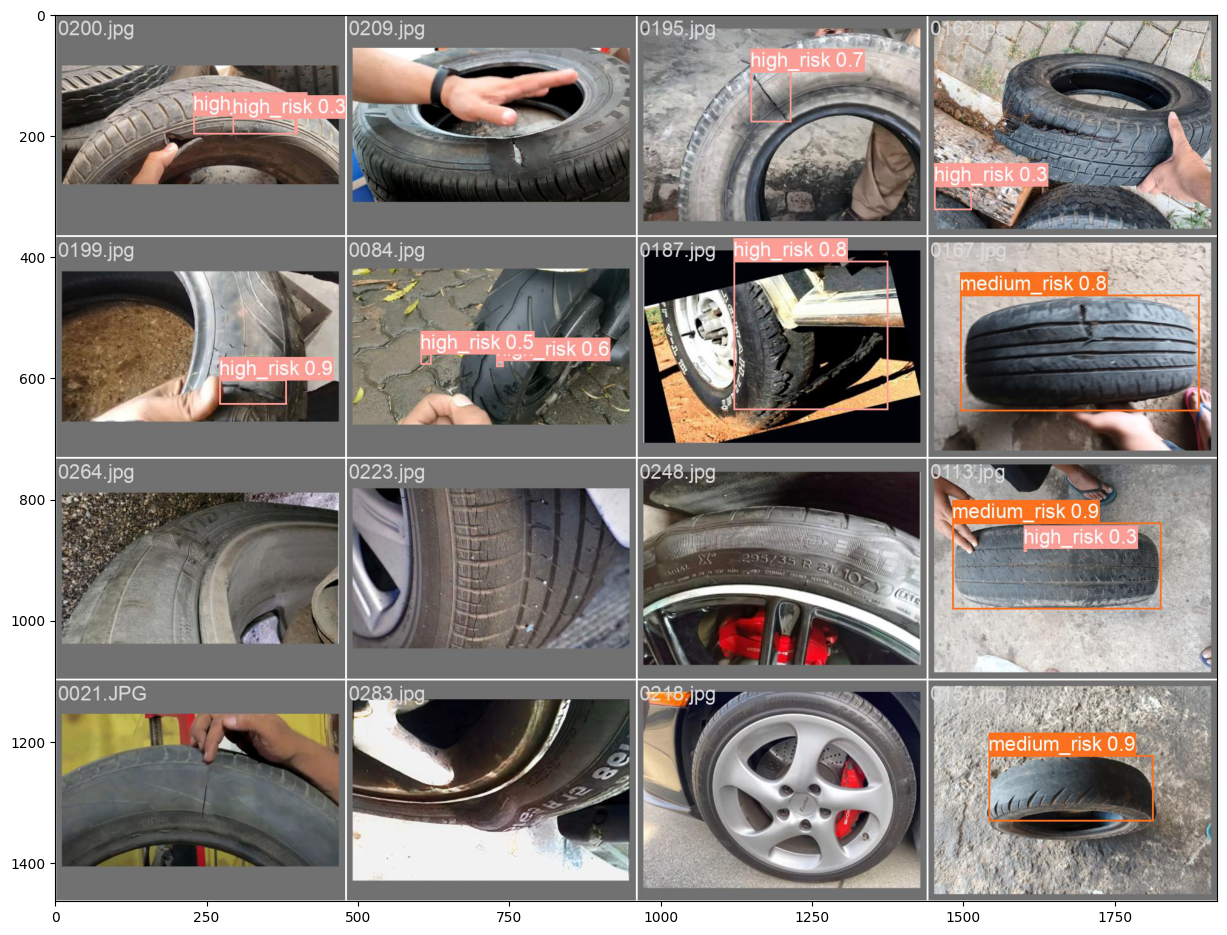

In [ ]:
#one batch with validation images with predicted labels 
plt.figure(figsize=(15,15))
plt.imshow(plt.imread(f'/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/val_batch0_pred.jpg'))

In [ ]:
%cd /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5

/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5


In [ ]:
!python detect.py --source /content/drive/MyDrive/FYP_CODE1/implementation_risk/test --weights /content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/weights/best.pt --img 640

detect: weights=['/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/FYP_CODE1/implementation_risk/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5m_custom summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/44 /content/drive/MyDrive/FYP_CODE1/implementation_risk/test/T001.jpg: 640x576 1 high_risk, 1012.3ms
image 2/44 /content/drive/MyDrive/FYP_CODE1/implementation_risk/test/T002.jpg: 480x640 1 low_risk, 1 high_risk, 1122.5ms
image 3/44 /content/drive/MyDrive

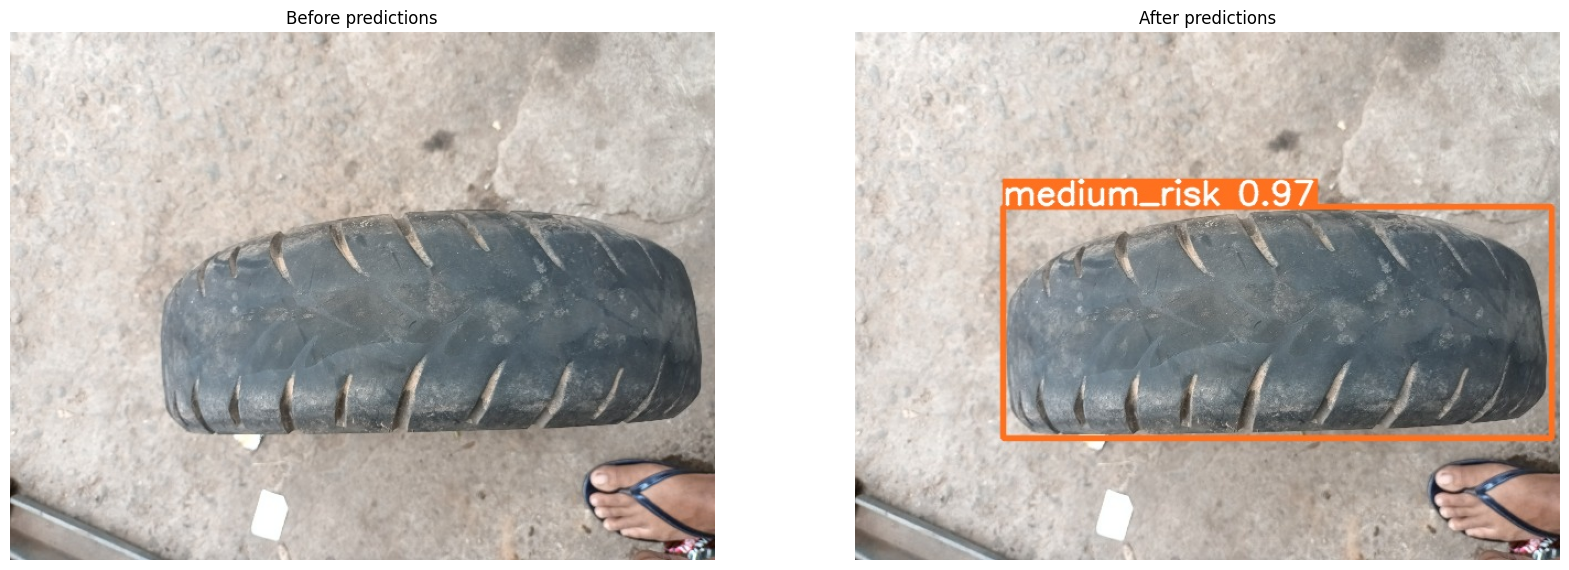

In [ ]:
import cv2 
# create figure
fig = plt.figure(figsize=(20,80))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = cv2.imread('/content/drive/MyDrive/FYP_CODE1/implementation_risk/test/T006.jpg')
Image2 = cv2.imread('/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/detect/exp/T006.jpg')

#convert the images to BGR format to RGB format 
Image1 =cv2.cvtColor(Image1,cv2.COLOR_BGR2RGB)
Image2 =cv2.cvtColor(Image2,cv2.COLOR_BGR2RGB)

fig.add_subplot(rows, columns, 1) 
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Before predictions")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("After predictions")
  
plt.show()

### Confusion Matrix for the validation set of the dataset

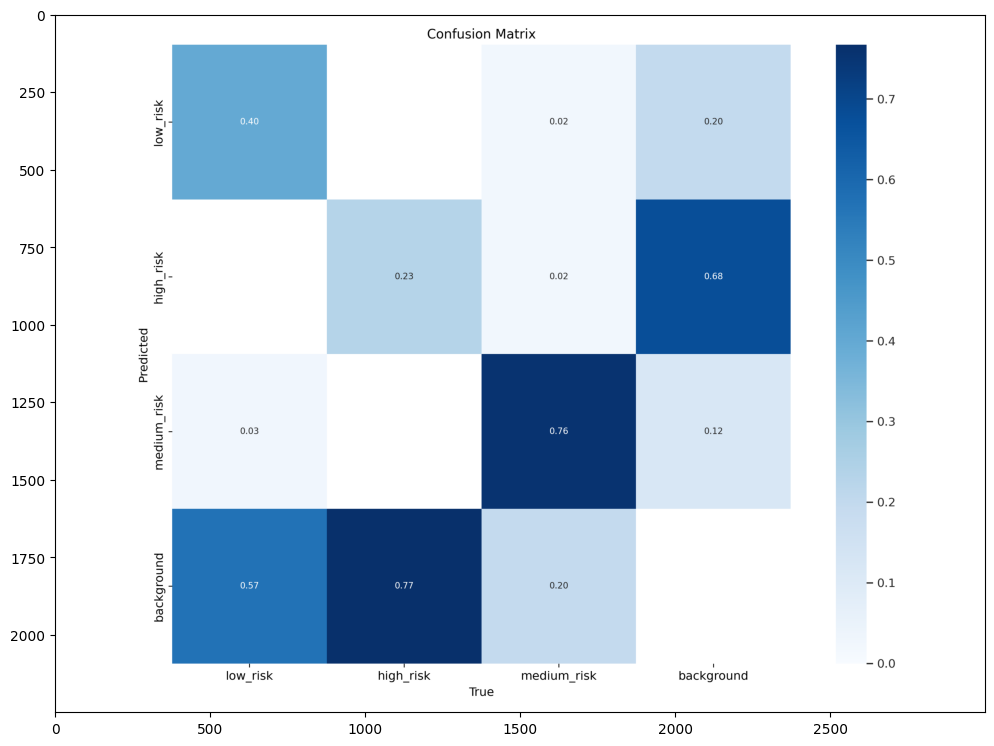

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread(f'/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/confusion_matrix.png'))

### F1-curve for the validation set of the dataset

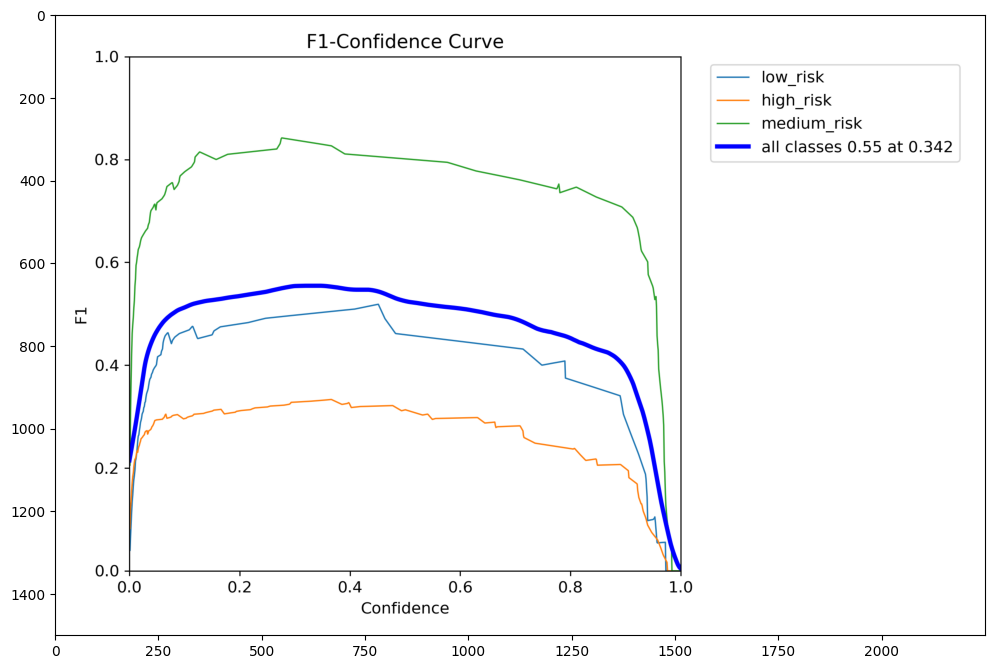

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread(f'/content/drive/MyDrive/FYP_CODE1/implementation_risk/yolov5/runs/train/exp/F1_curve.png'))